# Postprocesses MODIS data 

Downloaded data is in hd5 and we convert it to NetCDF for easy use with xarray. We use rioxarray to open the hd5 files. 

In [3]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 

import time


import netCDF4


f1 = Path('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/Not_collocated_T_AOD_and_CER_with_wind_and_FRP_all_cases_all_JJA_agg_for_Sara.nc')

f2 = '/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/Not_collocated_T_AOD_and_CER_with_wind_and_FRP_all_cases_all_JJA_agg_for_Sara_mean_time.nc'




default_varl = [
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
    'Cloud_Top_Temperature_Day_Maximum',
    'Cloud_Top_Temperature_Day_Mean',
    'Cloud_Top_Temperature_Day_Minimum',
    'Cloud_Top_Pressure_Day_Mean',
    'Cloud_Top_Pressure_Day_Maximum',
    'Cloud_Top_Pressure_Day_Minimum',
    'Cloud_Top_Height_Day_Mean',
    'Cloud_Top_Height_Day_Maximum',
    'Cloud_Top_Height_Day_Minimum',
    'Cloud_Fraction_Day_Mean',
    'Cloud_Fraction_Day_Maximum',
    'Cloud_Fraction_Day_Minimum',
    'Cloud_Optical_Thickness_Liquid_Maximum',
    'Cloud_Optical_Thickness_Liquid_Mean',
    'Cloud_Optical_Thickness_Liquid_Mean_Uncertainty',
    'Cloud_Optical_Thickness_Liquid_Minimum',
    'Cloud_Optical_Thickness_Liquid_Standard_Deviation',
    'Cloud_Optical_Thickness_Combined_Mean',
    'Cloud_Optical_Thickness_Combined_Maximum',
    'Cloud_Optical_Thickness_Combined_Minimum',
    'Cloud_Optical_Thickness_Combined_Standard_Deviation',
    'Cloud_Effective_Radius_Liquid_Mean_Uncertainty',
    'Cloud_Effective_Radius_Liquid_Mean',
]

def convert_hd5(fn_in, fn_out, varl = None):
    """
    Converts to netcdf and only variables in varl
    """
    start = time.time()

    if varl is None: 
        varl = default_varl
        
    modis_pre = rxr.open_rasterio(str(fn_in),
                              variable=varl,
                              #parse_coordinates=False,
                              # cache=True,
                              #chunks = True, 
                              #masked=True,
                              from_disk=True,
                              #export_grid_mapping=False
                             )
    modis_pre = fix_time_coord(modis_pre)
    # print(modis_pre)
    
    for v in modis_pre.data_vars:
        atts = modis_pre[v].attrs
        if 'add_offset' in atts:
            old_add_offset = atts['add_offset']
            scale_factor = atts['scale_factor']
            new_add_offset = -1*scale_factor*old_add_offset
            atts['modis_add_offset'] = old_add_offset
            atts['add_offset'] = new_add_offset
            
    modis_pre.to_netcdf(fn_out)
    end = time.time()
    print(f'Took {end - start} seconds to run')
    return modis_pre

def fix_time_coord(modis_pre):
    """
    Fixes the time stamps.
    """
    timestamp_beg = modis_pre.attrs['RANGEBEGINNINGDATE']+' '+ modis_pre.attrs['RANGEBEGINNINGTIME']
    timestamp_end = modis_pre.attrs['RANGEENDINGDATE']+' '+ modis_pre.attrs['RANGEENDINGTIME']
    time_beg = pd.to_datetime(timestamp_beg)
    time_end = pd.to_datetime(timestamp_end)

    modis_pre.attrs['timestamp_beginning'] = timestamp_beg
    modis_pre.attrs['timestamp_end'] = timestamp_end



    modis_pre['time'] = time_beg

    modis_pre = modis_pre.set_coords('time').expand_dims('time')
    return modis_pre

In [4]:
modis_pre = rxr.open_rasterio(
    '/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_raw/MYD08_D3.A2012001.061.2018037013520.hdf',
    #variable=varl,
    #parse_coordinates=False,
    # cache=True,
    # chunks = True, 
    # masked=True,
    from_disk=True,
    # export_grid_mapping=False
)

## Download 

Data originally downloaded from:
https://ladsweb.modaps.eosdis.nasa.gov/search/order/2/MYD08_D3--61

Only day values. 

## Paths: 

In [5]:
from bs_fdbck.constants import path_measurement_data

In [6]:
path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'

path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'

path_out_netcdf.mkdir(exist_ok=True)

fl = list(path_raw_data.glob('*.hdf'))
fl.sort()

## Convert files to nc

In [7]:
for f in fl:
    print(f'Processing {f.stem}...')
    
    fn_out = path_out_netcdf / f'{f.stem}_subset_vars.nc'
    if fn_out.exists():
        print(f'Skipping {fn_out.stem} because file already exists')
        continue
    #print(fn_out)
    modis_pre = convert_hd5(f,fn_out)

Processing MYD08_D3.A2012001.061.2018037013520...
Skipping MYD08_D3.A2012001.061.2018037013520_subset_vars because file already exists
Processing MYD08_D3.A2012002.061.2018037015827...
Skipping MYD08_D3.A2012002.061.2018037015827_subset_vars because file already exists
Processing MYD08_D3.A2012003.061.2018037021707...
Skipping MYD08_D3.A2012003.061.2018037021707_subset_vars because file already exists
Processing MYD08_D3.A2012004.061.2018037024048...
Skipping MYD08_D3.A2012004.061.2018037024048_subset_vars because file already exists
Processing MYD08_D3.A2012005.061.2018038162138...
Skipping MYD08_D3.A2012005.061.2018038162138_subset_vars because file already exists
Processing MYD08_D3.A2012006.061.2018038163847...
Skipping MYD08_D3.A2012006.061.2018038163847_subset_vars because file already exists
Processing MYD08_D3.A2012007.061.2018038171132...
Skipping MYD08_D3.A2012007.061.2018038171132_subset_vars because file already exists
Processing MYD08_D3.A2012008.061.2018038174046...
Skipp

## Produce file for each variable per year: 

In [8]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
    'Cloud_Top_Temperature_Day_Maximum',
    'Cloud_Top_Temperature_Day_Mean',
    'Cloud_Top_Temperature_Day_Minimum',

]
producw_files_extra=[
    'Cloud_Top_Temperature_Day_Maximum',
    'Cloud_Top_Temperature_Day_Mean',
    'Cloud_Top_Temperature_Day_Minimum',
    'Cloud_Top_Pressure_Day_Mean',
    'Cloud_Top_Pressure_Day_Maximum',
    'Cloud_Top_Pressure_Day_Minimum',
    'Cloud_Top_Height_Day_Mean',
    'Cloud_Top_Height_Day_Maximum',
    'Cloud_Top_Height_Day_Minimum',
    'Cloud_Fraction_Day_Mean',
    'Cloud_Fraction_Day_Maximum',
    'Cloud_Fraction_Day_Minimum',
    'Cloud_Optical_Thickness_Liquid_Maximum',
    #'Cloud_Optical_Thickness_Liquid_Mean',
    'Cloud_Optical_Thickness_Liquid_Mean_Uncertainty',
    'Cloud_Optical_Thickness_Liquid_Minimum',
    'Cloud_Optical_Thickness_Liquid_Standard_Deviation',
    'Cloud_Optical_Thickness_Combined_Mean',
    'Cloud_Optical_Thickness_Combined_Maximum',
    'Cloud_Optical_Thickness_Combined_Minimum',
    'Cloud_Optical_Thickness_Combined_Standard_Deviation',
    'Cloud_Effective_Radius_Liquid_Mean_Uncertainty',
    #'Cloud_Effective_Radius_Liquid_Mean',
]

#### Get list of input files:

In [9]:
fl = list(path_out_netcdf.glob('*.nc'))
fl.sort()
print(fl) 

[PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012001.061.2018037013520_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012002.061.2018037015827_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012003.061.2018037021707_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012004.061.2018037024048_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012005.061.2018038162138_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012006.061.2018038163847_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012007.061.2018038171132_subset_vars.nc'), PosixPath('/proj/bolinc/users/x_s

In [10]:
fl[0]

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2012001.061.2018037013520_subset_vars.nc')

In [11]:
fl_df = pd.DataFrame(fl, columns = ['path'])

fl_df['name'] = fl_df['path'].apply(lambda x:str(x.name))

fl_df['year'] = fl_df['name'].apply(lambda x: x.split('.')[1][1:5])

fl_df['ym'] = fl_df['name'].apply(lambda x: x.split('.')[1][1:7])

fl_df['ym']

0       201200
1       201200
2       201200
3       201200
4       201200
         ...  
2551    201836
2552    201836
2553    201836
2554    201836
2555    201900
Name: ym, Length: 2556, dtype: object

In [55]:
fl_df['year'].unique()

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'],
      dtype=object)

In [56]:
unique_years = fl_df['year'].unique()

## Open one year at a time and produce one file per variable

In [59]:
for yr in unique_years[:-1]:
    print(yr)
    fldf_sub = fl_df[fl_df['year'] == yr]
    fl_sub = list(fldf_sub['path'])
    #print(list(fldf_sub['name']))
    ds_sub = xr.open_mfdataset(fl_sub)
    
    for v in produce_files:
        fn_out = path_out_postproc / f'MYD08_D3_{v}_{yr}.nc'
        if not fn_out.exists():
            ds_sub[v].to_netcdf(fn_out)

2012
2013
2014
2015
2016
2017
2018


In [ ]:
fl_sub[:10]

In [ ]:
xr.open_mfdataset(fl_sub[:10])#,decode_cf=False )

In [ ]:
fl

## Extra:

In [6]:
ft = '/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_netcdf/MYD08_D3.A2014001.061.2018051055620_subset_vars.nc'

In [7]:
dst = xr.open_dataset(ft,decode_cf=False )

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [10]:
v = 'Cloud_Top_Temperature_Day_Mean'

In [11]:
dst[v] = dst[v].where(dst[v]!=-9999)

In [12]:
dst#[v]#.plot()

<xarray.Dataset>
Dimensions:                                              (y: 180, x: 360, band: 1, time: 1)
Coordinates:
  * y                                                    (y) float64 89.5 ......
  * x                                                    (x) float64 -179.5 ....
  * band                                                 (band) int64 1
  * time                                                 (time) int64 0
Data variables: (12/29)
    spatial_ref                                          int64 ...
    Cloud_Top_Temperature_Day_Mean                       (time, band, y, x) float64 ...
    Cloud_Top_Temperature_Day_Minimum                    (time, band, y, x) int16 ...
    Cloud_Top_Temperature_Day_Maximum                    (time, band, y, x) int16 ...
    Cloud_Top_Pressure_Day_Mean                          (time, band, y, x) int16 ...
    Cloud_Top_Pressure_Day_Minimum                       (time, band, y, x) int16 ...
    ...                                                   ...
    Cloud_Effective_Radius_Liquid_Mean_Uncertainty       (time, band, y, x) int16 ...
    Cloud_Water_Path_Liquid_Mean                         (time, band, y, x) int16 ...
    Cloud_Water_Path_Liquid_Standard_Deviation           (time, band, y, x) int16 ...
    Cloud_Water_Path_Liquid_Minimum                      (time, band, y, x) int16 ...
    Cloud_Water_Path_Liquid_Maximum                      (time, band, y, x) int16 ...
    Cloud_Water_Path_Liquid_Mean_Uncertainty             (time, band, y, x) int16 ...
Attributes: (12/31)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:   MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:     Aqua
    ASSOCIATEDSENSORSHORTNAME.1:       MODIS
    DAYNIGHTFLAG:                      Both
    DESCRREVISION:                     6.1
    EASTBOUNDINGCOORDINATE:            180.0
    ...                                ...
    SHORTNAME:                         MYD08_D3
    SOUTHBOUNDINGCOORDINATE:           -90.0
    VERSIONID:                         61
    WESTBOUNDINGCOORDINATE:            -180.0
    timestamp_beginning:               2014-01-01 00:00:00
    timestamp_end:                     2014-01-02 00:00:00

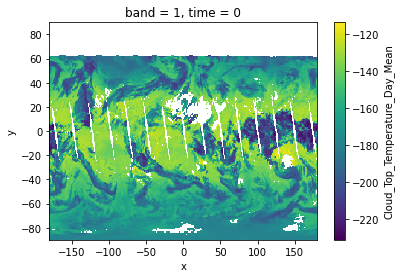

In [13]:
(((dst[v]- dst[v].attrs['add_offset'])*dst[v].attrs['scale_factor'])-273.15).plot()

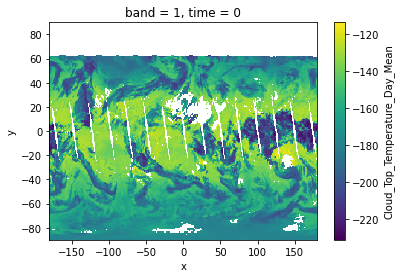

In [14]:
(((dst[v]- dst[v].attrs['add_offset'])*dst[v].attrs['scale_factor'])-273.15).plot()

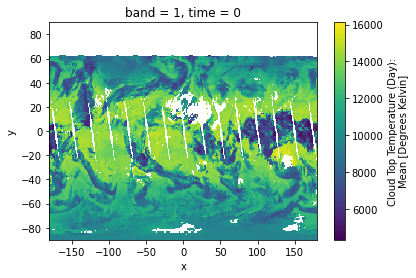

In [15]:
dst[v].plot()

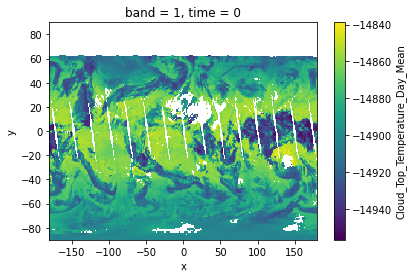

In [16]:
(dst[v]*0.00999999977648258 - 15000.0).plot()

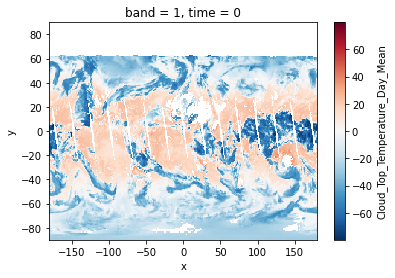

In [17]:
(((dst[v]- dst[v].attrs['modis_add_offset'])*dst[v].attrs['scale_factor'])-273.15).plot()

In [18]:
da_t1 =((dst[v]- dst[v].attrs['modis_add_offset'])*dst[v].attrs['scale_factor'])-273.15

In [19]:
dst2 = xr.open_dataset(ft,decode_cf=True )

In [20]:
dst2

<xarray.Dataset>
Dimensions:                                              (y: 180, x: 360, band: 1, time: 1)
Coordinates:
  * y                                                    (y) float64 89.5 ......
  * x                                                    (x) float64 -179.5 ....
  * band                                                 (band) int64 1
  * time                                                 (time) datetime64[ns] ...
Data variables: (12/29)
    spatial_ref                                          int64 ...
    Cloud_Top_Temperature_Day_Mean                       (time, band, y, x) float32 ...
    Cloud_Top_Temperature_Day_Minimum                    (time, band, y, x) float32 ...
    Cloud_Top_Temperature_Day_Maximum                    (time, band, y, x) float32 ...
    Cloud_Top_Pressure_Day_Mean                          (time, band, y, x) float32 ...
    Cloud_Top_Pressure_Day_Minimum                       (time, band, y, x) float32 ...
    ...                                                   ...
    Cloud_Effective_Radius_Liquid_Mean_Uncertainty       (time, band, y, x) float32 ...
    Cloud_Water_Path_Liquid_Mean                         (time, band, y, x) float32 ...
    Cloud_Water_Path_Liquid_Standard_Deviation           (time, band, y, x) float32 ...
    Cloud_Water_Path_Liquid_Minimum                      (time, band, y, x) float32 ...
    Cloud_Water_Path_Liquid_Maximum                      (time, band, y, x) float32 ...
    Cloud_Water_Path_Liquid_Mean_Uncertainty             (time, band, y, x) float32 ...
Attributes: (12/31)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:   MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:     Aqua
    ASSOCIATEDSENSORSHORTNAME.1:       MODIS
    DAYNIGHTFLAG:                      Both
    DESCRREVISION:                     6.1
    EASTBOUNDINGCOORDINATE:            180.0
    ...                                ...
    SHORTNAME:                         MYD08_D3
    SOUTHBOUNDINGCOORDINATE:           -90.0
    VERSIONID:                         61
    WESTBOUNDINGCOORDINATE:            -180.0
    timestamp_beginning:               2014-01-01 00:00:00
    timestamp_end:                     2014-01-02 00:00:00

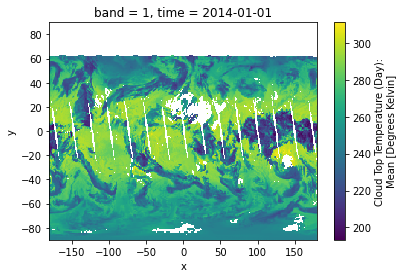

In [21]:
dst2[v].plot()

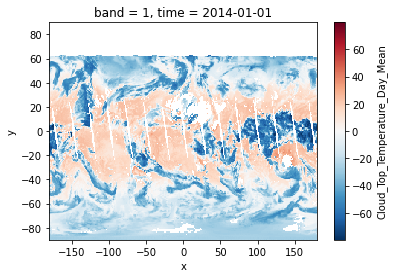

In [22]:
(dst2[v]-273.15).plot()

In [23]:
da_t2 = dst2[v]-273.15

In [24]:
da_t1

<xarray.DataArray 'Cloud_Top_Temperature_Day_Mean' (time: 1, band: 1, y: 180, x: 360)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [-26.57000551, -26.80000551, -26.71000551, ..., -26.86000551,
          -27.0500055 , -26.8800055 ],
         [-27.57000549, -28.07000548, -27.72000549, ..., -27.95000548,
          -28.72000546, -28.18000548],
         [-26.9700055 , -27.1100055 , -27.35000549, ..., -28.39000547,
          -27.60000549, -27.62000549]]]])
Coordinates:
  * y        (y) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * x        (x) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5 179.5
  * band     (band) int64 1
  * time     (time) int64 0

In [25]:
da_t2.squeeze()

<xarray.DataArray 'Cloud_Top_Temperature_Day_Mean' (y: 180, x: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-26.570007, -26.799988, -26.709991, ..., -26.859985, -27.049988,
        -26.880005],
       [-27.570007, -28.070007, -27.720001, ..., -27.949997, -28.720001,
        -28.179993],
       [-26.970001, -27.109985, -27.350006, ..., -28.39    , -27.600006,
        -27.619995]], dtype=float32)
Coordinates:
  * y        (y) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * x        (x) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5 179.5
    band     int64 1
    time     datetime64[ns] 2014-01-01

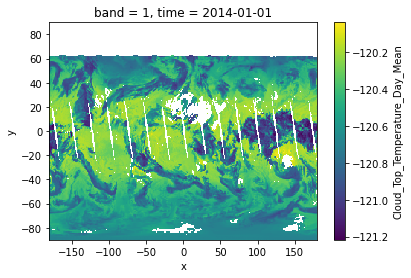

In [26]:
(((dst2[v]+ 15000.0)*0.00999999977648258)-273.15).plot()

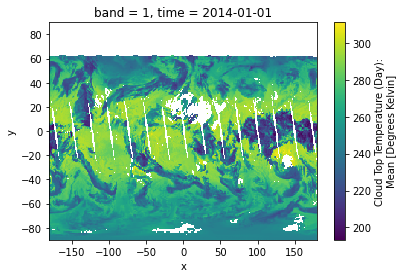

In [27]:
dst2[v].plot()

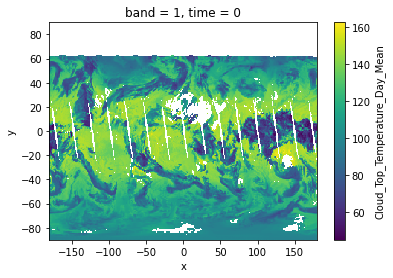

In [28]:
((dst[v]+ dst[v].attrs['add_offset'])*dst[v].attrs['scale_factor']).plot()

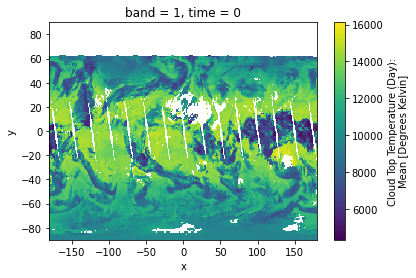

In [29]:
dst['Cloud_Top_Temperature_Day_Mean'].where(dst[v]!=-9999).plot()

In [30]:
fl = list(path_out_netcdf.glob('*.nc'))[:100]

ds_conc = xr.open_mfdataset(fl, concat_dim='time').squeeze('band')

In [31]:
ds_conc

<xarray.Dataset>
Dimensions:                                              (y: 180, x: 360, time: 100)
Coordinates:
  * y                                                    (y) float64 89.5 ......
  * x                                                    (x) float64 -179.5 ....
    band                                                 int64 1
  * time                                                 (time) datetime64[ns] ...
Data variables: (12/29)
    spatial_ref                                          (time) int64 0 0 ... 0
    Cloud_Top_Temperature_Day_Mean                       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Top_Temperature_Day_Minimum                    (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Top_Temperature_Day_Maximum                    (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Top_Pressure_Day_Mean                          (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Top_Pressure_Day_Minimum                       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                                                   ...
    Cloud_Effective_Radius_Liquid_Mean_Uncertainty       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Water_Path_Liquid_Mean                         (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Water_Path_Liquid_Standard_Deviation           (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Water_Path_Liquid_Minimum                      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Water_Path_Liquid_Maximum                      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    Cloud_Water_Path_Liquid_Mean_Uncertainty             (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/31)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:   MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:     Aqua
    ASSOCIATEDSENSORSHORTNAME.1:       MODIS
    DAYNIGHTFLAG:                      Both
    DESCRREVISION:                     6.1
    EASTBOUNDINGCOORDINATE:            180.0
    ...                                ...
    SHORTNAME:                         MYD08_D3
    SOUTHBOUNDINGCOORDINATE:           -90.0
    VERSIONID:                         61
    WESTBOUNDINGCOORDINATE:            -180.0
    timestamp_beginning:               2012-01-15 00:00:00
    timestamp_end:                     2012-01-16 00:00:00

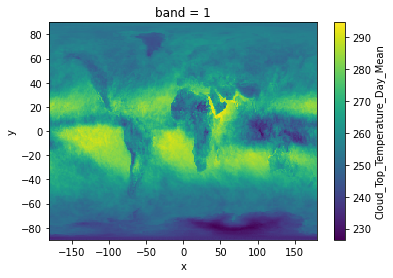

In [32]:
ds_conc['Cloud_Top_Temperature_Day_Mean'].mean('time').plot()

In [33]:
import matplotlib.pyplot as plt

In [34]:
_da = ds_conc['Cloud_Top_Temperature_Day_Mean']

In [35]:
_da.attrs

{'long_name': 'Cloud Top Temperature (Day): Mean',
 'units': 'Degrees Kelvin',
 'modis_add_offset': -15000.0,
 'grid_mapping': 'spatial_ref'}

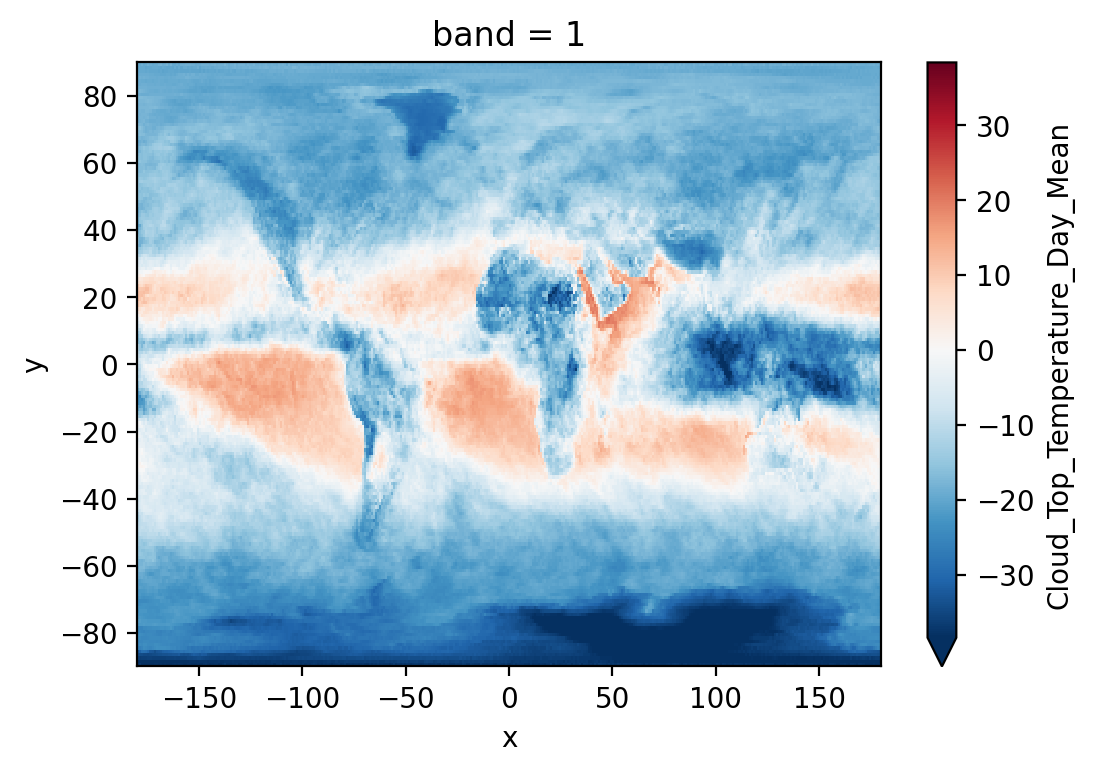

In [36]:
fig, ax = plt.subplots(dpi=200)
(ds_conc['Cloud_Top_Temperature_Day_Mean'].mean('time')-273.15).plot(robust=True, ax=ax)#={'dpi':200})

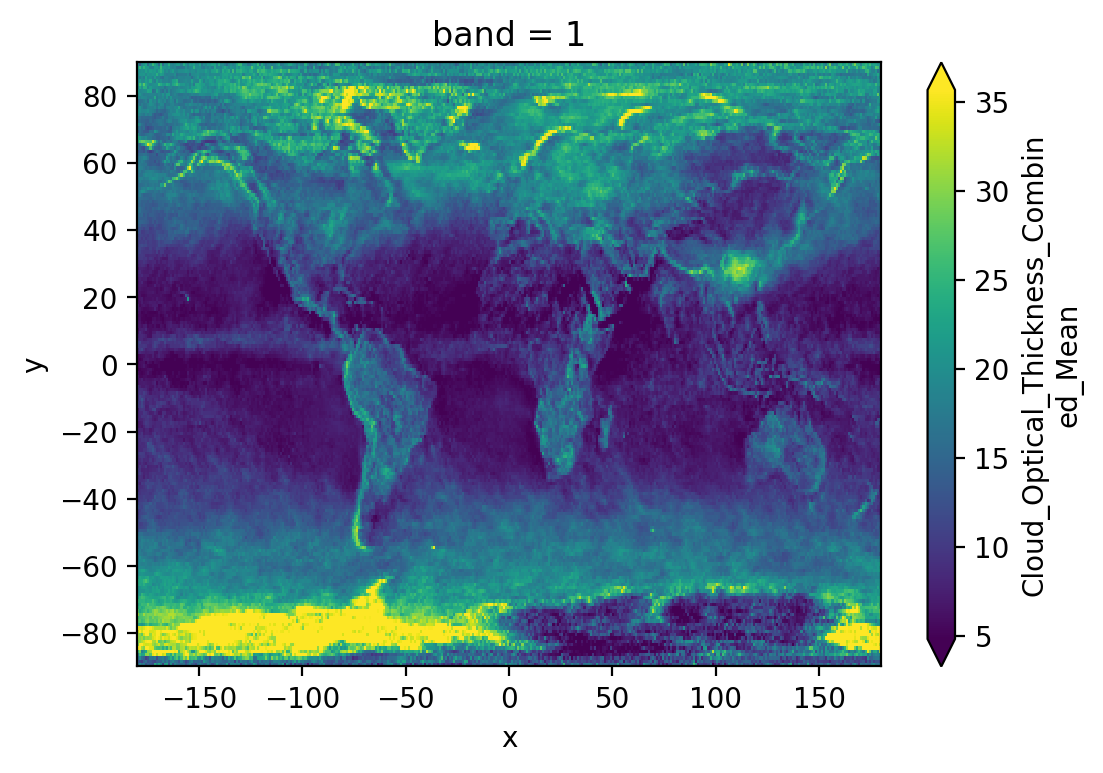

In [37]:
fig, ax = plt.subplots(dpi=200)
ds_conc['Cloud_Optical_Thickness_Combined_Mean'].mean('time').plot(robust=True, ax=ax)#={'dpi':200})

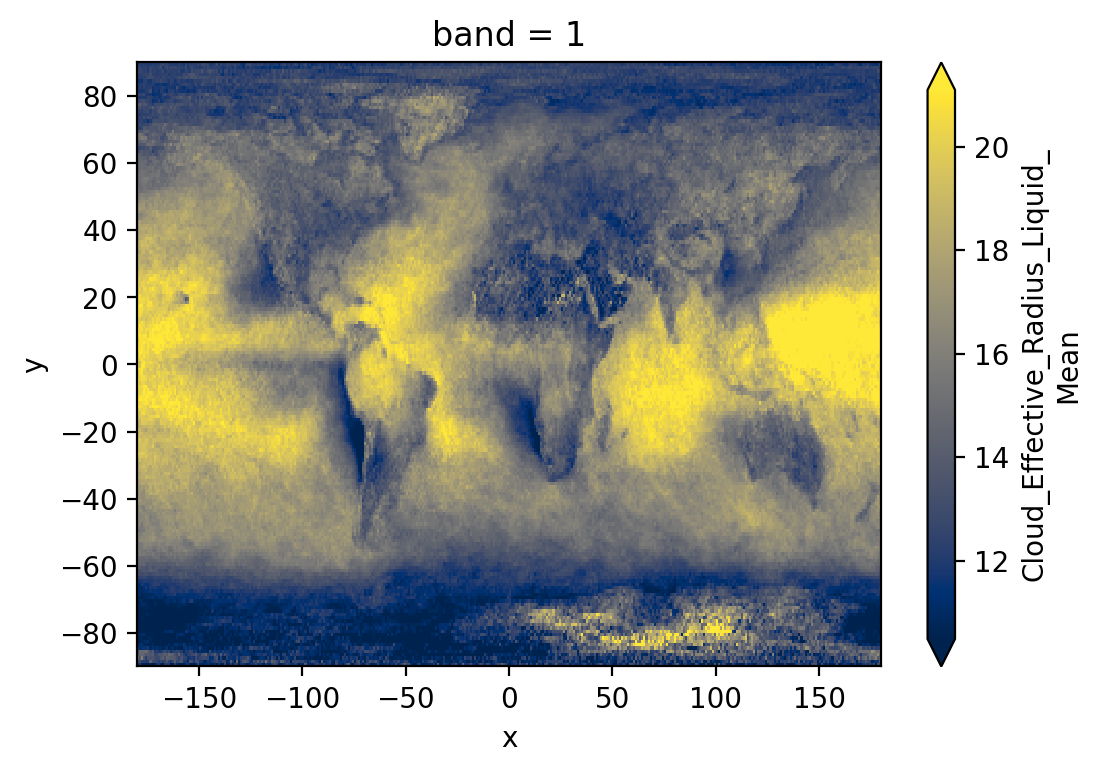

In [38]:
fig, ax = plt.subplots(dpi = 200)
ds_conc['Cloud_Effective_Radius_Liquid_Mean'].mean('time').plot(robust=True, ax=ax, cmap='cividis')#={'dpi':200})

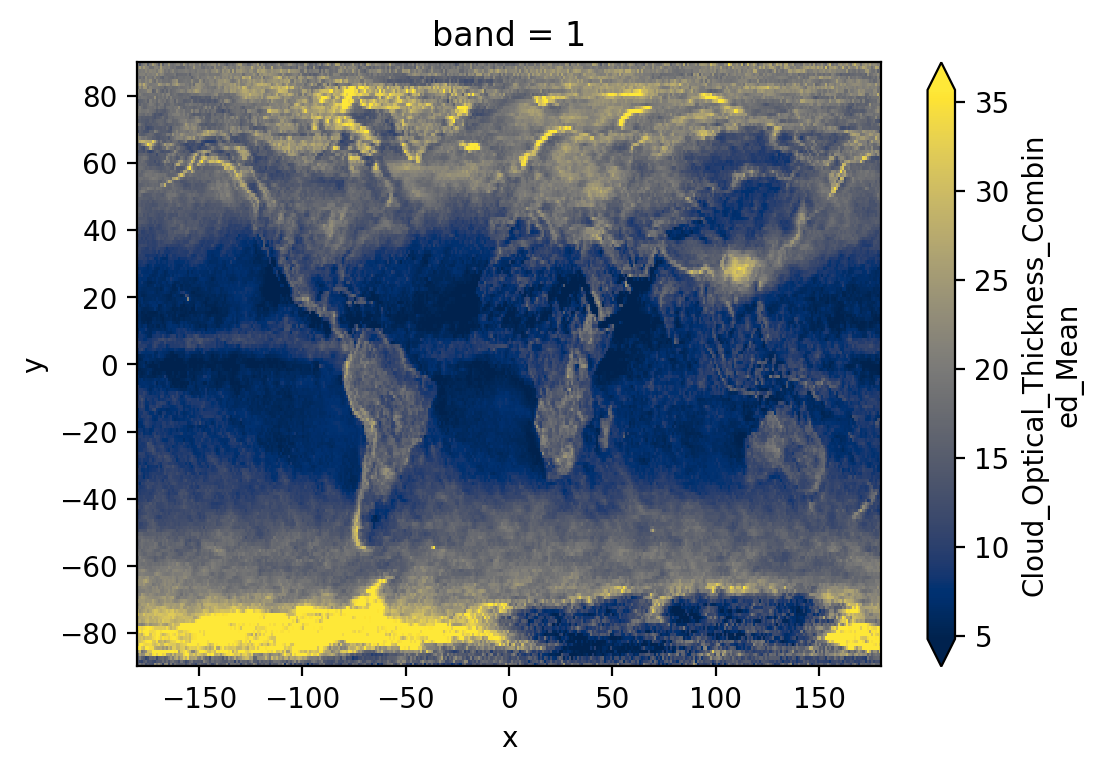

In [39]:
fig, ax = plt.subplots(dpi = 200)
ds_conc['Cloud_Optical_Thickness_Combined_Mean'].mean('time').plot(robust=True, ax=ax, cmap='cividis')#={'dpi':200})

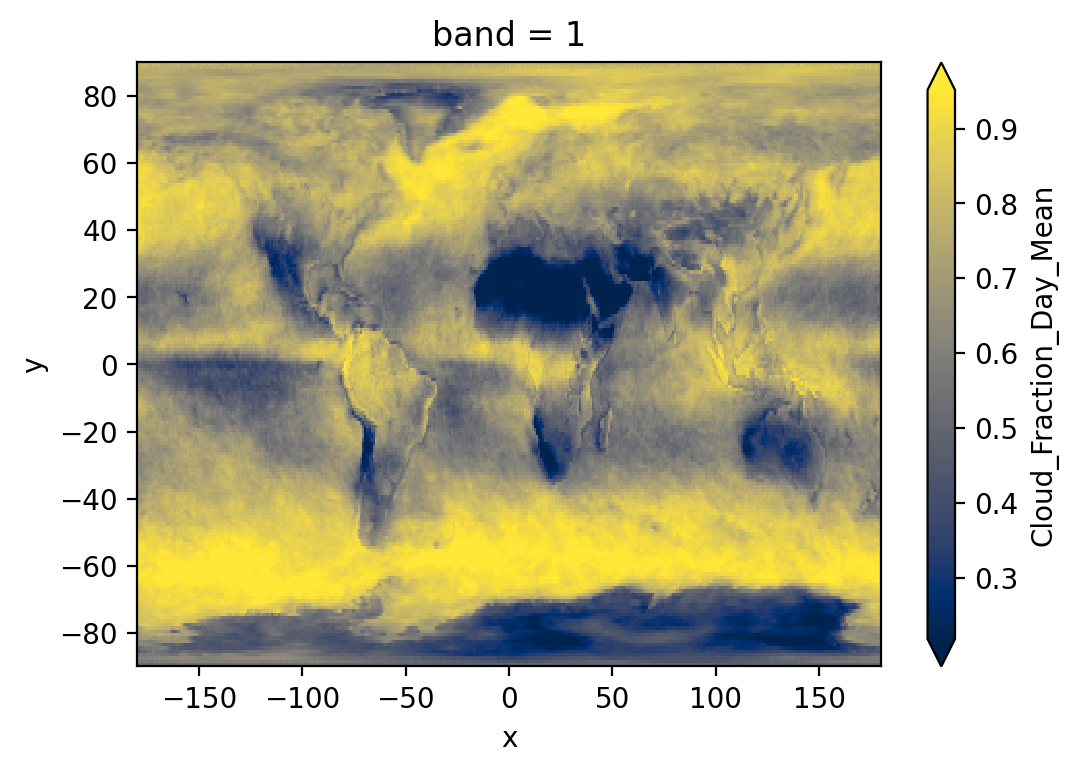

In [40]:
fig, ax = plt.subplots(dpi = 200)
ds_conc['Cloud_Fraction_Day_Mean'].mean('time').plot(robust=True, ax=ax, cmap='cividis')#={'dpi':200})

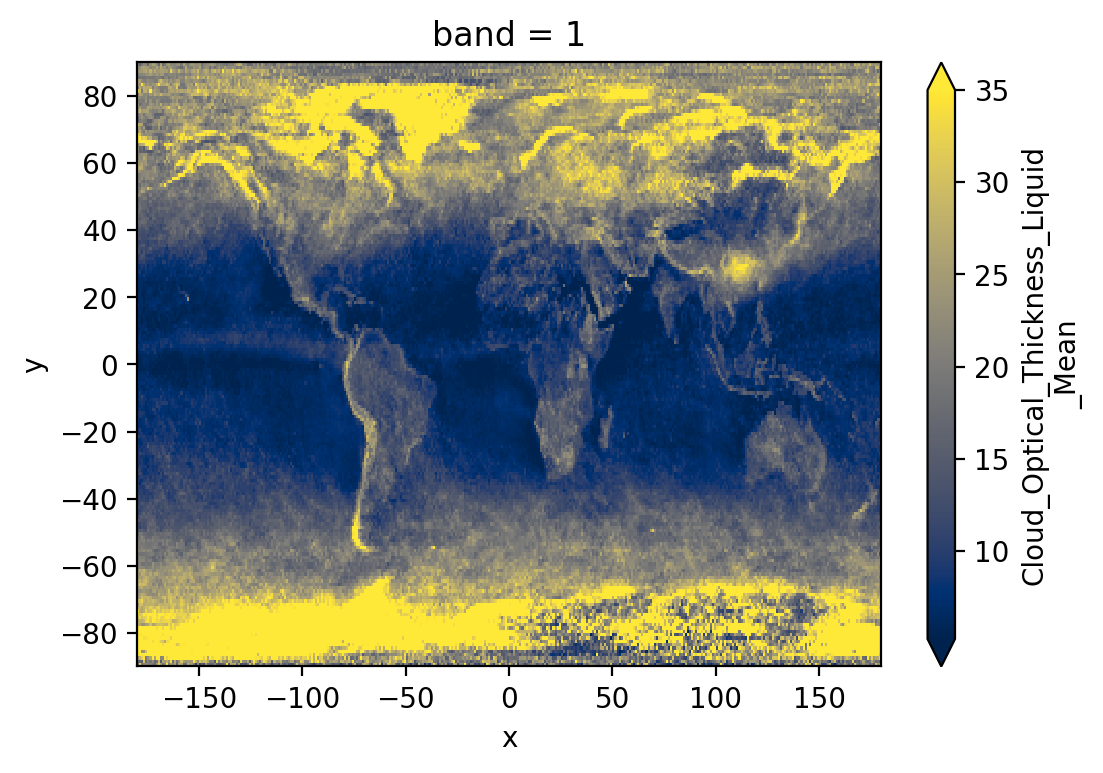

In [41]:
fig, ax = plt.subplots(dpi = 200)
ds_conc['Cloud_Optical_Thickness_Liquid_Mean'].mean('time').plot(robust=True, ax=ax, cmap='cividis', vmax=35)#={'dpi':200})

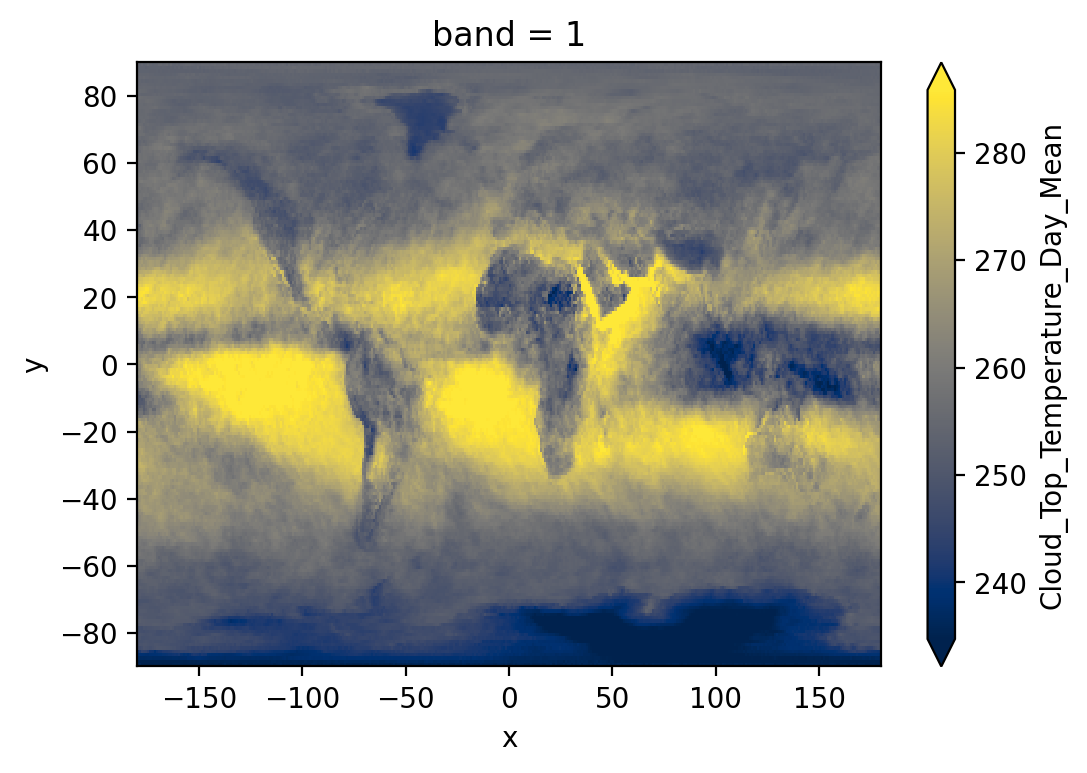

In [42]:
fig, ax = plt.subplots(dpi = 200)
ds_conc['Cloud_Top_Temperature_Day_Mean'].mean('time').plot(robust=True, ax=ax, cmap='cividis')#={'dpi':200})

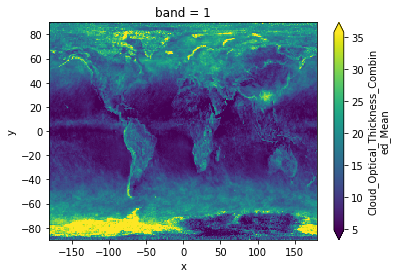

In [43]:
ds_conc['Cloud_Optical_Thickness_Combined_Mean'].mean('time').plot(robust=True)

In [44]:
import matplotlib.pyplot as plt

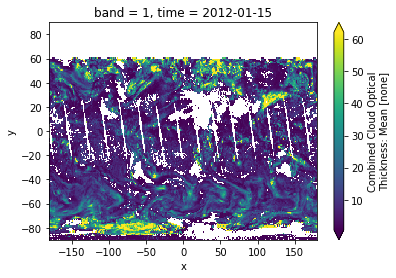

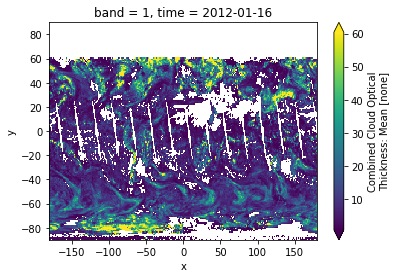

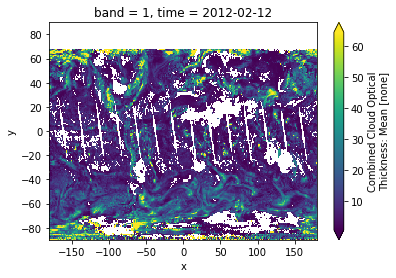

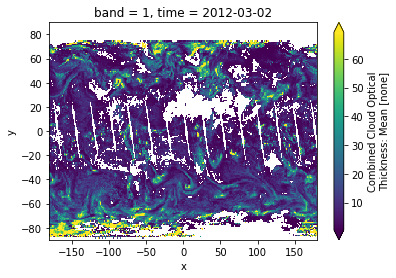

In [45]:
for i in range(4):
    ds_conc['Cloud_Optical_Thickness_Combined_Mean'].isel(time=i).plot(robust=True)
    plt.show()